In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
import os
import kagglehub

def download_and_get_csv_path(dataset_name, version_path="/root/.cache/kagglehub/datasets"):

    dataset_path = kagglehub.dataset_download(dataset_name)

    csv_file = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".csv"):
                csv_file = os.path.join(root, file)
                break
        if csv_file:
            break

    return csv_file

def load_data(dataset_path):
    data = pd.read_csv(dataset_path)
    return data

try:
    dataset_name = "harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows"
    csv_path = download_and_get_csv_path(dataset_name)
    data = load_data(csv_path)
    print(f"Data loaded successfully. Number of records: {len(data)}")
except FileNotFoundError as e:
    print(f"Error: FileNotFound {e}")
except Exception as e:
    print(f"Error: {e}")


100%|██████████| 175k/175k [00:00<00:00, 15.1MB/s]

Extracting files...
Data loaded successfully. Number of records: 1000


In [ ]:
data.head(5)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [ ]:
df = data
df = df.dropna(subset=["Series_Title", "Runtime", "IMDB_Rating", "Director", "Overview"])


In [ ]:
def create_document(row):
    genres = [g.strip().lower() for g in row["Genre"].split(",")]

    director = [row["Director"].lower().replace(" ", "_")]

    runtime = row["Runtime"]
    if isinstance(runtime, str):
        runtime_token = runtime.split()[0]
    else:
        runtime_token = str(runtime)

    rating = row["IMDB_Rating"]
    rating_token = f"rating_{int(round(rating))}"

    tokens = genres + director + [runtime_token, rating_token]
    return tokens

documents = df.apply(create_document, axis=1).tolist()
documents[0]

['drama', 'frank_darabont', '142', 'rating_9']

In [ ]:
w2v_model = Word2Vec(sentences=documents, vector_size=100, window=3, min_count=1, workers=4, seed=42)

def get_w2v_representation(doc_tokens):
    token_vectors = []
    for token in doc_tokens:
        if token in w2v_model.wv:
            token_vectors.append(w2v_model.wv[token])
    if token_vectors:
        return np.mean(token_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# słownik: tytuł filmu -> wektor (Word2Vec)
w2v_embeddings = {}
for idx, row in df.iterrows():
    title = row["Series_Title"]
    tokens = create_document(row)
    w2v_embeddings[title] = get_w2v_representation(tokens)


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()
    return cls_embedding

# słownik: tytuł filmu -> embedding (BERT)
bert_embeddings = {}
for idx, row in df.iterrows():
    title = row["Series_Title"]
    overview = row["Overview"]
    bert_embeddings[title] = get_bert_embedding(overview)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def recommend_w2v(input_title, embeddings, top_n=5):
    if input_title not in embeddings:
        print(f"Film {input_title} nie został znaleziony.")
        return []
    input_vec = embeddings[input_title].reshape(1, -1)
    titles = list(embeddings.keys())
    vectors = np.array([embeddings[t] for t in titles])

    similarities = cosine_similarity(input_vec, vectors)[0]

    sorted_indices = np.argsort(-similarities)
    recommendations = []
    for idx in sorted_indices:
        if titles[idx] != input_title:
            recommendations.append((titles[idx], similarities[idx]))
        if len(recommendations) >= top_n:
            break
    return recommendations

def recommend_bert(input_title, embeddings, top_n=5):
    if input_title not in embeddings:
        print(f"Film {input_title} nie został znaleziony.")
        return []
    input_vec = embeddings[input_title].reshape(1, -1)
    titles = list(embeddings.keys())
    vectors = np.array([embeddings[t] for t in titles])

    similarities = cosine_similarity(input_vec, vectors)[0]
    sorted_indices = np.argsort(-similarities)
    recommendations = []
    for idx in sorted_indices:
        if titles[idx] != input_title:
            recommendations.append((titles[idx], similarities[idx]))
        if len(recommendations) >= top_n:
            break
    return recommendations

In [ ]:
input_movie = "The Godfather"

print("Rekomendacje oparte na Word2Vec:")
w2v_recs = recommend_w2v(input_movie, w2v_embeddings, top_n=10)
for rec, score in w2v_recs:
    print(f"{rec} (podobieństwo: {score:.3f})")

print("\nRekomendacje oparte na BERT:")
bert_recs = recommend_bert(input_movie, bert_embeddings, top_n=10)
for rec, score in bert_recs:
    print(f"{rec} (podobieństwo: {score:.3f})")


Rekomendacje oparte na Word2Vec:
The Godfather: Part II (podobieństwo: 0.999)
The Godfather: Part III (podobieństwo: 0.999)
After Hours (podobieństwo: 0.999)
Goodfellas (podobieństwo: 0.999)
Wind River (podobieństwo: 0.999)
12 Angry Men (podobieństwo: 0.999)
Taxi Driver (podobieństwo: 0.999)
The King of Comedy (podobieństwo: 0.999)
The Sting (podobieństwo: 0.999)
Adams æbler (podobieństwo: 0.999)

Rekomendacje oparte na BERT:
Sunset Blvd. (podobieństwo: 0.922)
Gladiator (podobieństwo: 0.922)
Chinatown (podobieństwo: 0.921)
Dead Man's Shoes (podobieństwo: 0.915)
Kingsman: The Secret Service (podobieństwo: 0.915)
Inside Man (podobieństwo: 0.914)
The Pursuit of Happyness (podobieństwo: 0.913)
Hell or High Water (podobieństwo: 0.913)
Dip huet seung hung (podobieństwo: 0.911)
Barry Lyndon (podobieństwo: 0.909)


In [ ]:
input_movie = "The Dark Knight"

print("Rekomendacje oparte na Word2Vec:")
w2v_recs = recommend_w2v(input_movie, w2v_embeddings, top_n=10)
for rec, score in w2v_recs:
    print(f"{rec} (podobieństwo: {score:.3f})")

print("\nRekomendacje oparte na BERT:")
bert_recs = recommend_bert(input_movie, bert_embeddings, top_n=10)
for rec, score in bert_recs:
    print(f"{rec} (podobieństwo: {score:.3f})")


Rekomendacje oparte na Word2Vec:
Lord of War (podobieństwo: 0.999)
Haider (podobieństwo: 0.999)
Hell or High Water (podobieństwo: 0.999)
Män som hatar kvinnor (podobieństwo: 0.999)
Enter the Dragon (podobieństwo: 0.999)
3:10 to Yuma (podobieństwo: 0.999)
Sicario (podobieństwo: 0.999)
End of Watch (podobieństwo: 0.999)
Baby Driver (podobieństwo: 0.999)
The Fugitive (podobieństwo: 0.999)

Rekomendacje oparte na BERT:
Joker (podobieństwo: 0.891)
Spider-Man: Into the Spider-Verse (podobieństwo: 0.886)
Batman Begins (podobieństwo: 0.881)
Avengers: Infinity War (podobieństwo: 0.877)
Star Wars: Episode VII - The Force Awakens (podobieństwo: 0.874)
Thor: Ragnarok (podobieństwo: 0.873)
The Avengers (podobieństwo: 0.873)
Harry Potter and the Deathly Hallows: Part 1 (podobieństwo: 0.869)
Terminator 2: Judgment Day (podobieństwo: 0.867)
Indiana Jones and the Last Crusade (podobieństwo: 0.866)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
def get_primary_genre(row):
    return row["Genre"].split(",")[0].strip().lower()

df["Primary_Genre"] = df.apply(get_primary_genre, axis=1)

titles = df["Series_Title"].tolist()
genres = df["Primary_Genre"].tolist()

w2v_data = []
w2v_genres = []
for title, genre in zip(titles, genres):
    if title in w2v_embeddings:
        w2v_data.append(w2v_embeddings[title])
        w2v_genres.append(genre)
w2v_data = np.array(w2v_data)

bert_data = []
bert_genres = []
for title, genre in zip(titles, genres):
    if title in bert_embeddings:
        bert_data.append(bert_embeddings[title])
        bert_genres.append(genre)
bert_data = np.array(bert_data)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)

w2v_tsne = tsne.fit_transform(w2v_data)
bert_tsne = tsne.fit_transform(bert_data)



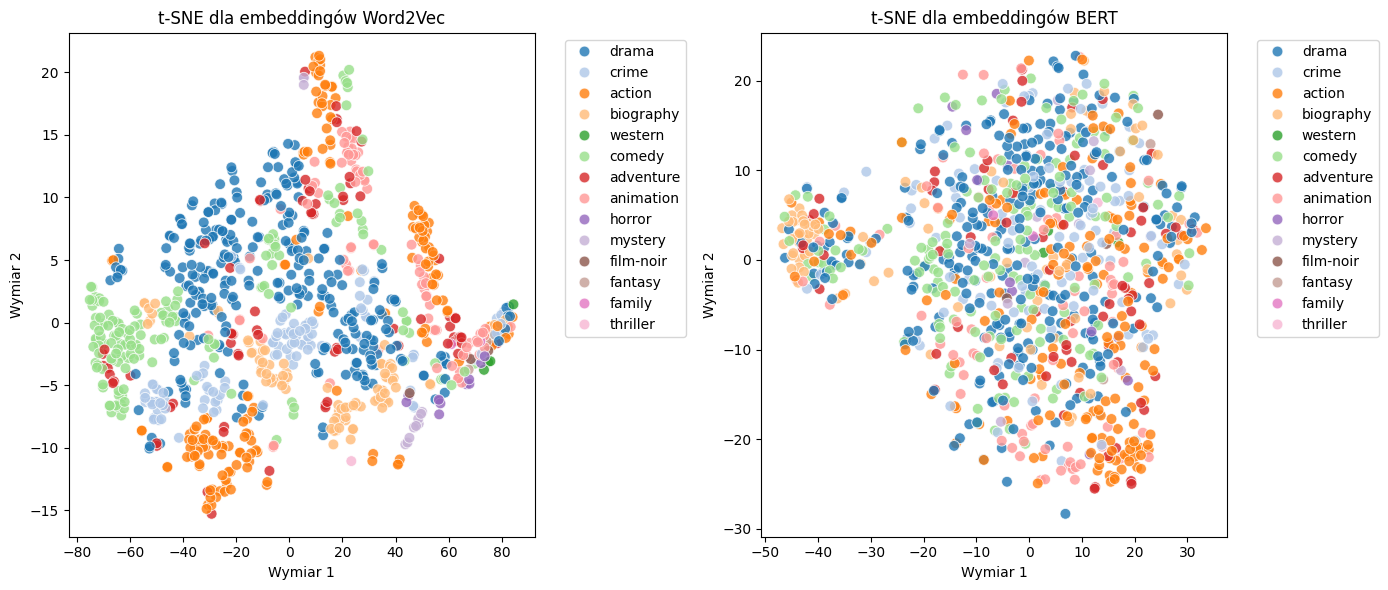

In [ ]:
plt.figure(figsize=(14, 6))

# Word2Vec
plt.subplot(1, 2, 1)
sns.scatterplot(x=w2v_tsne[:, 0], y=w2v_tsne[:, 1], hue=w2v_genres, palette="tab20", s=60, alpha=0.8)
plt.title("t-SNE dla embeddingów Word2Vec")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# BERT
plt.subplot(1, 2, 2)
sns.scatterplot(x=bert_tsne[:, 0], y=bert_tsne[:, 1], hue=bert_genres, palette="tab20", s=60, alpha=0.8)
plt.title("t-SNE dla embeddingów BERT")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [ ]:
df = df.dropna(subset=["Genre", "Overview", "Director"])

def get_primary_genre(genre_str):
    return genre_str.split(",")[0].strip()

df["Primary_Genre"] = df["Genre"].apply(get_primary_genre)

df["combined_text"] = df["Overview"] + " " + df["Director"]

X = df["combined_text"]
y = df["Primary_Genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred))

def predict_movie_genre(overview: str, director: str) -> str:
    text = overview + " " + director
    predicted_genre = pipeline.predict([text])[0]
    return predicted_genre

example_overview = "A young programmer is selected to participate in a secret project involving artificial intelligence."
example_director = "Christopher Nolan"

predicted = predict_movie_genre(example_overview, example_director)
print(f"Przewidywany gatunek filmu: {predicted}")


Raport klasyfikacji:
              precision    recall  f1-score   support

      Action       0.57      0.45      0.50        29
   Adventure       0.00      0.00      0.00        14
   Animation       0.00      0.00      0.00        20
   Biography       0.00      0.00      0.00        21
      Comedy       0.29      0.07      0.11        30
       Crime       0.00      0.00      0.00        16
       Drama       0.33      0.87      0.47        63
     Fantasy       0.00      0.00      0.00         1
   Film-Noir       0.00      0.00      0.00         1
      Horror       0.00      0.00      0.00         1
     Mystery       0.00      0.00      0.00         4

    accuracy                           0.35       200
   macro avg       0.11      0.13      0.10       200
weighted avg       0.23      0.35      0.24       200

Przewidywany gatunek filmu: Action


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
n, i = 10, 0
n = len(data)
count = 0
for idx, movie in data.iterrows():

    movie_overview = movie["Overview"]
    movie_director = movie["Director"]
    predicted_genre = predict_movie_genre(example_overview, example_director)
    if predicted_genre in movie["Genre"]:
        count += 1
    # print(f"Film: {movie['Series_Title']}, Przewidywany gatunek: {predicted_genre}, Prawdziwy gatunek: {movie['Genre']}")
    i += 1
    if i == n:
        break
print(f"Dokładność predykcji: {count}/{n}")

Dokładność predykcji: 189/1000


In [ ]:
print(X_test.iloc[0])
print(y_test.iloc[0])

A woman struggles to find a way to live her life after the death of her husband and child. Krzysztof Kieslowski
Drama
